In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas_datareader as pdr
import datetime
today = datetime.date.today()

In [2]:
def Black_Scholes_price(S, K, T, r, sigma, option_type): # assume risk-free-rate = 0
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        delta = norm.cdf(d1)
    elif option_type == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        delta = -norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    theta = -S * norm.pdf(d1) * sigma / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2)
    vega = S * norm.pdf(d1) * np.sqrt(T)
    
    return option_price, delta, gamma, theta, vega

In [3]:
def Get_rfr():
    risk_free_rate = pd.DataFrame()
    shifted_date = 0
    while risk_free_rate.empty:
        risk_free_rate = pdr.DataReader('DGS3MO', 'fred', today - datetime.timedelta(days=shifted_date)).dropna()
        shifted_date += 1
    return risk_free_rate.values[0][0]/100

In [10]:
def find_arbitrage(ticker_symbol):
    ticker = yf.Ticker(ticker_symbol)
    expiration = ticker.options[1]  # Get the closest option chain
    option_chain = ticker.option_chain(expiration)
    calls = option_chain.calls
    #calls = calls[calls.openInterest >= 50]
    puts = option_chain.puts
    #puts = puts[puts.openInterest >= 50]

    calls['contractType'] = "call"
    puts['contractType'] = "put"
    
    current_price = ticker.info['currentPrice']
    calls['current_price'] = current_price
    
    risk_free_rate = Get_rfr()
    for df in [calls, puts]:
        df['TheoreticalPrice'],df['delta'],df['gamma'],df['theta'],df['vega'] = np.where(
            (df['openInterest'] > 50),
            Black_Scholes_price(current_price, df['strike'], (pd.Timestamp(expiration) - pd.Timestamp.now()).days / 365,
                                        risk_free_rate, df['impliedVolatility'], df['contractType'].iloc[0]),
            np.nan
        )
    #Here we use lastPrice for demonstration purpose, you should be using ask or bit
    calls['Discrepancy'] = calls['TheoreticalPrice'] - calls['lastPrice']
    puts['Discrepancy'] = puts['TheoreticalPrice'] - puts['lastPrice']
    
    significant_calls = calls[calls['Discrepancy'] > calls['lastPrice']*0.0]
    significant_puts = puts[puts['Discrepancy'] > puts['lastPrice']*0.0]

    print(f'The current price for {ticker_symbol} is {current_price},')
    print(f"Found {len(significant_calls)} potential call arbitrage opportunities")
    print(f"Found {len(significant_puts)} potential put arbitrage opportunities")
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.scatter(calls['strike'], calls['Discrepancy'], label='Calls', alpha=0.5)
    plt.scatter(puts['strike'], puts['Discrepancy'], label='Puts', alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Strike Price')
    plt.ylabel('Discrepancy ($)')
    plt.title(f'Option price discrepancy for {ticker_symbol}')
    plt.legend()
    plt.show()
    
    return significant_calls, significant_puts

The current price for NOW is 897.585,
Found 5 potential call arbitrage opportunities
Found 1 potential put arbitrage opportunities


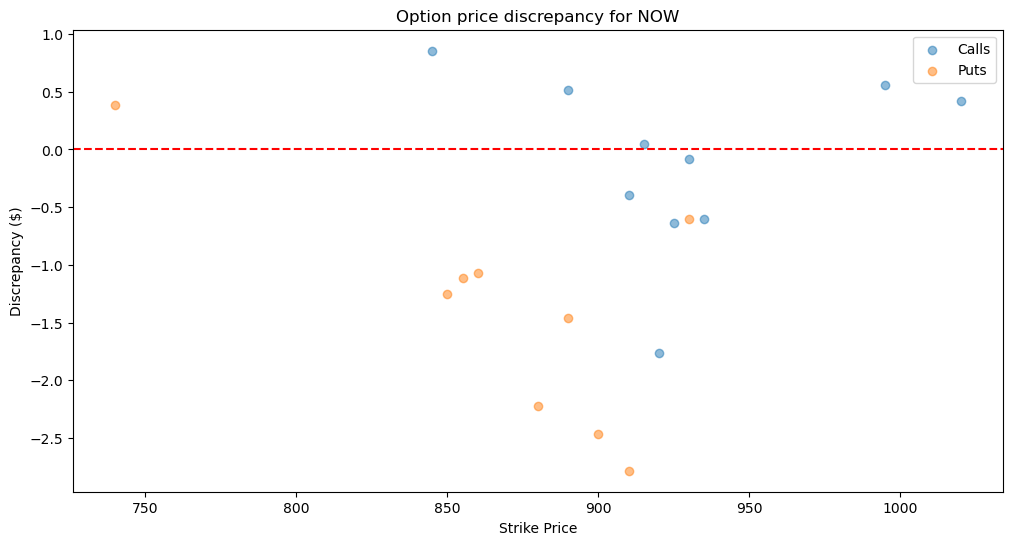


Top 5 Call Arbitrage Opportunities:
----------------------------------------
        contractSymbol             lastTradeDate  strike  lastPrice   bid  \
8   NOW241004C00845000 2024-09-17 14:51:28+00:00   845.0      56.80  52.2   
38  NOW241004C00995000 2024-09-24 17:14:39+00:00   995.0       0.61   0.0   
18  NOW241004C00890000 2024-09-25 14:25:56+00:00   890.0      20.50  20.9   

     ask  change  percentChange  volume  openInterest  ...  contractSize  \
8   58.5    0.00       0.000000     2.0            83  ...       REGULAR   
38   1.9    0.00       0.000000   100.0           101  ...       REGULAR   
18  22.4  -27.59     -57.371593     3.0            57  ...       REGULAR   

    currency contractType current_price TheoreticalPrice     delta     gamma  \
8        USD         call       897.585        57.655391  0.853242  0.004254   
38       USD         call       897.585         1.167201  0.051575  0.001917   
18       USD         call       897.585        21.013403  0.590862  

In [38]:
Stock = "NOW"
significant_calls, significant_puts = find_arbitrage(Stock)

# Display the top 5 arbitrage opportunities for calls and puts
print("\nTop 5 Call Arbitrage Opportunities:")
print('----------------------------------------')
print(significant_calls.sort_values('Discrepancy', ascending=False).head(3))
print("=======================================================================================")
print("\nTop 5 Put Arbitrage Opportunities:")
print('-----------------------------------------')
print(significant_puts.sort_values('Discrepancy', ascending=False).head(3))

In [40]:
#Instant Delta hedging:
def Create_Delta_hedging(options):
    if options.empty:
        print("No arbitrage found")
        return 
    portfolio = pd.DataFrame()
    portfolio['contractSymbol'] = options['contractSymbol']
    portfolio['option volume'] = options['volume']
    portfolio['share volume'] = options['delta']*options['volume']
    portfolio['require cash'] = options['delta']*options['volume']*options['current_price'] + options['ask']*options['volume']
    portfolio['cash flow'] = np.where(options['Discrepancy']>0,- options['ask'],options['ask']) + options['delta']*options['current_price']
    return portfolio
Pi = Create_Delta_hedging(significant_calls)

In [42]:
Total_cash_flow = Pi['cash flow'].sum()
Require_cash = Pi['require cash'].sum()
print(f'Total cash flow is {Total_cash_flow} USD')
print(f'Require cash is {Require_cash} USD')
print(f'Max profit is {Total_cash_flow/Require_cash*100}%')

Total cash flow is 1591.9598524238932 USD
Require cash is 14033.965671948165 USD
Max profit is 11.343620824197874%
